# 11. Linear Regression

## 11.7 Bayesian linear regression

### 11.7.6 Dealing with multicollinearity

> We illustrate multicollinearity using the example in sec 6.1 of
> [Statistical Rethinking ed 2](https://xcelab.net/rm/statistical-rethinking/).
>
> The numpyro code is from
> [Du Phan's site](https://fehiepsi.github.io/rethinking-numpyro/06-the-haunted-dag-and-the-causal-terror.html)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
rng = np.random.default_rng()

# number of individuals
N = 100
height_std = np.sqrt(2)
leg_std = np.sqrt(0.02)

# sim total height of each
height = rng.normal(loc=10, scale=height_std, size=N)
# leg as proportion of height
leg_prop = rng.uniform(low=0.4, high=0.5, size=N)
# sim left leg as proportion + error
leg_left = leg_prop * height + rng.normal(scale=leg_std, size=N)
# sim right leg as proportion + error
leg_right = leg_prop * height + rng.normal(scale=leg_std, size=N)

height.mean(), leg_left.mean(), leg_right.mean()

(10.017395881230913, 4.491372811706422, 4.498979909659536)

In [3]:
import pymc as pm

with pm.Model():
    a = pm.Normal('α', mu=0, sigma=10)
    bl = pm.Normal('βl', mu=0, sigma=10)
    br = pm.Normal('βr', mu=0, sigma=10)
    sigma = pm.Exponential('σ', lam=1)
    mu = pm.Deterministic('μ', a + bl * leg_left + br * leg_right)
    height_pred = pm.Normal('height_pred', mu=mu, sigma=sigma, observed=height)
    trace = pm.sample(draws=1000, cores=1, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [α, βl, βr, σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 50 seconds.


In [4]:
pm.summary(trace, var_names=['α', 'βl', 'βr', 'σ'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.479,0.393,0.758,2.217,0.011,0.008,1277.0,1118.0,1.0
βl,1.131,0.322,0.544,1.751,0.011,0.008,826.0,701.0,1.0
βr,0.768,0.331,0.141,1.352,0.012,0.009,759.0,754.0,1.0
σ,0.622,0.046,0.541,0.710,0.001,0.001,1275.0,1097.0,1.0


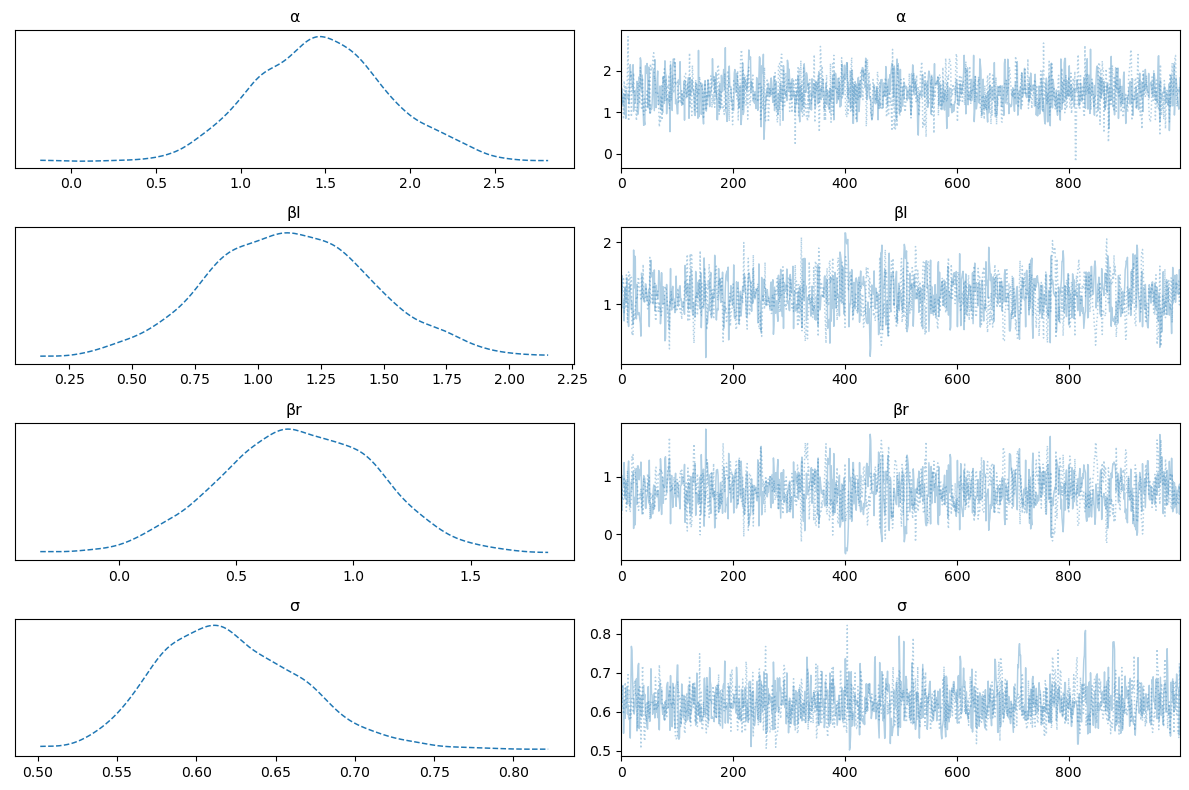

In [5]:
pm.plot_trace(
    trace, var_names=['α', 'βl', 'βr', 'σ'], combined=True,
    backend_kwargs={'tight_layout': True}
);

#### Figure 11.23: Posterior marginals for the parameters in the multi-leg example.

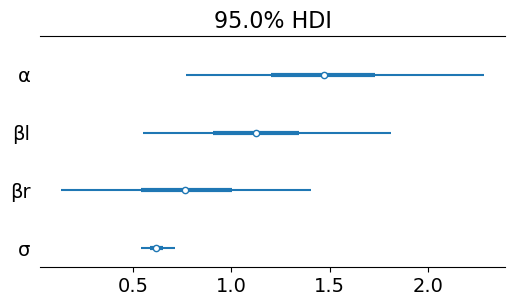

In [6]:
pm.plot_forest(
    trace, var_names=['α', 'βl', 'βr', 'σ'], combined=True, hdi_prob=0.95,
    figsize=(6, 3)
);

#### Figure 11.24: Posteriors for the multi-leg example. (a) Joint posterior $p(\beta_l,\beta_r|\mathcal{D})$. (b) Posterior of $p(\beta_l+\beta_r|\mathcal{D})$.

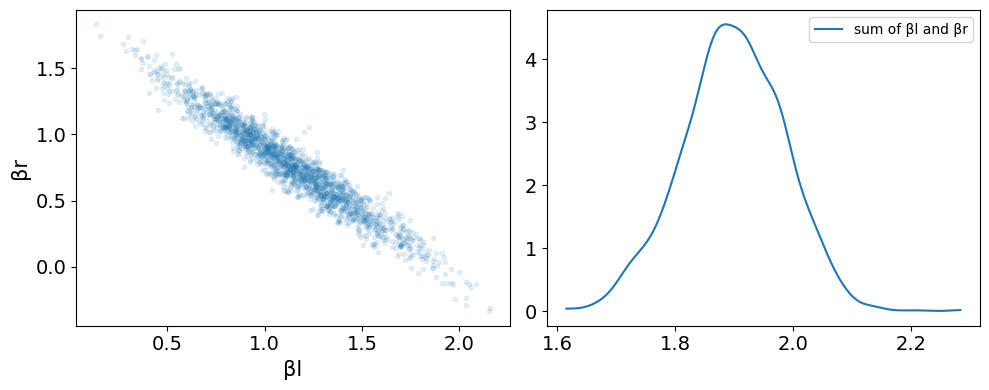

In [7]:
_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4), tight_layout=True)
pm.plot_pair(
    trace, var_names=['βl', 'βr'], scatter_kwargs={'alpha': 0.1}, ax=ax1
)
sum_βl_βr = trace.posterior['βl'].values + trace.posterior['βr'].values
pm.plot_kde(sum_βl_βr, label='sum of βl and βr', ax=ax2);